[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/cmaes.ipynb)

# Optimizing with CMA-ES in Jax

This notebook shows how to use QDax to find performing parameters on Rastrigin and Sphere problems with [CMA-ES](https://arxiv.org/pdf/1604.00772.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ES optimizer
- how to launch a certain number of optimizing steps
- how to visualise the optimization process

In [1]:
from jax.config import config
# config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES
from qdax.core.cmaes_sep import SepCMAES

import jax.profiler

import gc

import os
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.9"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

## Set the hyperparameters

In [2]:
#@title Hyperparameters
#@markdown ---
num_iterations = 100 #@param {type:"integer"}
num_dimensions = 25000 #@param {type:"integer"}
batch_size = 36 #@param {type:"integer"}
num_best = 18 #@param {type:"integer"}
sigma_g = 0.5 # 0.5 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
optim_problem = "rastrigin" #@param["rastrigin", "sphere"]
#@markdown ---

## Define the fitness function - choose rastrigin or sphere

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

if optim_problem == "sphere":
    fitness_fn = sphere_scoring
elif optim_problem == "rastrigin":
    fitness_fn = jax.vmap(rastrigin_scoring)
else:
    raise Exception("Invalid opt function name given")

## Define a CMA-ES optimizer instance

In [4]:
cmaes = SepCMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions,
    fitness_function=fitness_fn,
    mean_init=jnp.zeros((num_dimensions,)),
    init_sigma=sigma_g,
    delay_eigen_decomposition=True,
)

## Init the CMA-ES optimizer state

In [5]:
state = cmaes.init()
random_key = jax.random.PRNGKey(0)

## Run optimization iterations

In [6]:
%%time

iteration_count = 0
from tqdm import tqdm
for it in tqdm(range(num_iterations)):
    iteration_count += 1
    
    # sample
    samples, random_key = cmaes.sample(state, random_key)
    
    # udpate
    state = cmaes.update(state, samples)
    
    # check stop condition
    stop_condition = cmaes.stop_condition(state)

    if stop_condition:
        break
        
print("Num iterations before stop condition: ", iteration_count)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: mul got incompatible shapes for broadcasting: (25000,), (900000,).

## Check final fitnesses and distribution mean

In [7]:
# checking final fitness values
fitnesses = fitness_fn(samples)

print("Min fitness in the final population: ", jnp.min(fitnesses))
print("Mean fitness in the final population: ", jnp.mean(fitnesses))
print("Max fitness in the final population: ", jnp.max(fitnesses))

# checking mean of the final distribution
print("Final mean of the distribution: \n", means[-1])
# print("Final covariance matrix of the distribution: ", covs[-1])

Min fitness in the final population:  -13670.693
Mean fitness in the final population:  -13315.524
Max fitness in the final population:  -12915.125
Final mean of the distribution: 
 [-1.9759809e+00  1.5390862e-02 -8.6341995e-01 -1.3282036e+00
  2.7393618e+00  1.2388365e+00  2.0392864e+00  3.1659436e+00
  4.0036569e+00  3.9112993e-02  1.8640758e+00  2.1535780e+00
  8.6426383e-01  9.4921398e-01  5.0676646e+00  1.0926694e+00
 -9.7322452e-04  5.0070673e-01  2.1877708e+00  7.7478814e-01
 -4.6118751e-02 -1.0877222e+00 -1.8695702e-01  1.0113447e+00
 -6.8625021e-01  2.2187243e+00  2.1059151e+00  2.0263600e+00
  3.0203369e+00  9.5297700e-01  1.5188955e+00  2.1333003e+00
  2.0488925e+00  2.8360412e+00  1.8096101e-01  2.1053183e+00
  2.1369665e+00  3.0380759e+00  1.0053291e+00  2.1834533e+00
  8.0965322e-01  1.2617571e+00  3.1801093e+00  5.2783818e+00
 -1.0145006e+00  4.0768180e+00  2.3363647e+00  2.7561967e+00
  2.1985784e+00  1.7112713e-01  1.1400107e+00  1.5289254e+00
  4.7744408e+00  8.222990

## Visualization of the optimization trajectory

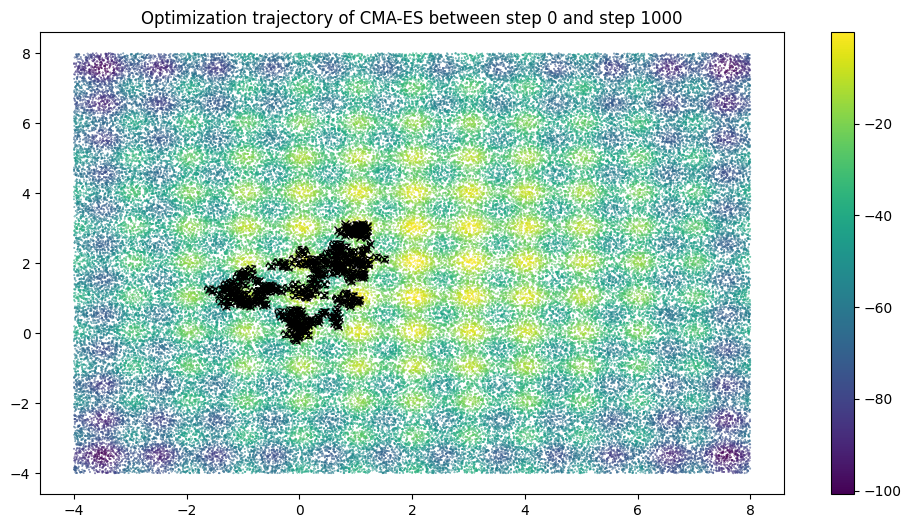

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# sample points to show fitness landscape
random_key, subkey = jax.random.split(random_key)
x = jax.random.uniform(subkey, minval=-4, maxval=8, shape=(100000, 2))
f_x = fitness_fn(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
traj_min = 0
traj_max = iteration_count
for mean, cov in zip(means[traj_min:traj_max], covs[traj_min:traj_max]):
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')
    
ax.set_title(f"Optimization trajectory of CMA-ES between step {traj_min} and step {traj_max}")
plt.show()

In [10]:
%matplotlib inline